----------------- Options ---------------
                 CUT_mode: CUT                           
                      amp: False                         
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: placeholder                   
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
               easy_label: experiment_name               
                    epoch: latest                        
                     eval: False                         
        flip_equivariance: False                         
                  gpu_ids: 1                             
              image_dir_A: /data/sina/datasets/seb/SA_files_processed/
              image_dir_B: /data/sina/dataset/seb/mms2_processed/Philips/
 

/data/sina/projects/code/CUT/.venv/lib/python3.7/site-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
100%|██████████| 50/50 [00:02<00:00, 19.13it/s]


FID between fake and Philips images for epoch test_10 is 328.6411550698842


  0%|          | 0/50 [00:00<?, ?it/s]

FID between fake and 7T images for epoch test_10 is 360.69073592068617


100%|██████████| 50/50 [00:02<00:00, 20.64it/s]


FID between fake and Philips images for epoch test_15 is 241.11150386708192


  2%|▏         | 1/50 [00:00<00:05,  9.56it/s]

FID between fake and 7T images for epoch test_15 is 408.44916429206967


100%|██████████| 50/50 [00:02<00:00, 18.68it/s]


FID between fake and Philips images for epoch test_20 is 333.90954980505165


  0%|          | 0/270 [00:00<?, ?it/s]

FID between fake and 7T images for epoch test_20 is 331.4266723970802


100%|██████████| 270/270 [00:11<00:00, 22.96it/s]


FID between fake and Philips images for epoch test_25 is 271.98162573056356


  6%|▌         | 3/50 [00:00<00:01, 27.06it/s]

FID between fake and 7T images for epoch test_25 is 265.2841322265511


100%|██████████| 50/50 [00:01<00:00, 31.30it/s]


FID between fake and Philips images for epoch test_30 is 296.7745230605529


  0%|          | 0/50 [00:00<?, ?it/s]

FID between fake and 7T images for epoch test_30 is 349.85456240214955


100%|██████████| 50/50 [00:01<00:00, 27.50it/s]


FID between fake and Philips images for epoch test_35 is 330.1195078812017


  0%|          | 0/50 [00:00<?, ?it/s]

FID between fake and 7T images for epoch test_35 is 332.09325615130246


100%|██████████| 50/50 [00:01<00:00, 26.31it/s]


FID between fake and Philips images for epoch test_5 is 307.86348317126317
FID between fake and 7T images for epoch test_5 is 378.4455278861867


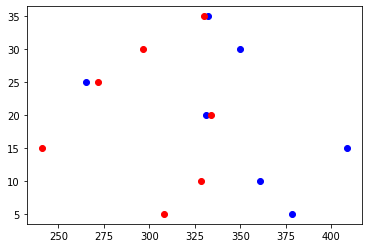

<Figure size 432x288 with 0 Axes>

In [1]:
import sys
sys.argv=['']
del sys
# calculate the FID score for epochs of differet CUT models
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html
import util.util as util

import nibabel as nib
import numpy as np
import os
from PIL import Image 

import matplotlib.pyplot as plt
import numpy as np

#====================================================================================== general testing parameters ======================================================================================
opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.


## train options
# opt.name = 'cmr_test_210719'
# opt.name = 'cmr_test_hinge_210720'
# opt.name = 'cmr_test_original_cut_210721'
# opt.epoch = '25' # epoch 5 to 35
opt.dataset_mode = 'cmr'
opt.model = 'cut'
opt.nce_idt = True
opt.amp = False
opt.direction = 'BtoA'
opt.lambda_identity = 0.5
opt.valid_data = True
opt.image_dir_A = '/data/sina/dataset/seb/SA_files_processed/'
opt.image_dir_B = '/data/sina/dataset/seb/mms2_processed/Philips/'

opt.max_dataset_size = 5850 
opt.output_nc =  1 
opt.input_nc = 1 
opt.batch_size = 1
opt.num_patches = 16 

opt.display_freq = 50
opt.update_html_freq = 50
opt.save_epoch_freq = 10
opt.evaluation_freq = 500
# opt.normG = 'batch'
# opt.normD = 'batch'
# opt.netD = 'n_layers'   # with the basic discriminator i see GAN artifacts in the translated images and that might be a sign of the fact that the discriminator gets trained faster
# opt.netD = 'multi_scale'
# opt.n_layers_D = 4
opt.n_epochs  = 50
opt.n_epochs_decay = 50
opt.log_file = opt.checkpoints_dir + '/' + opt.name +  '/loss_log.txt'
opt.loss_freq = 1000
opt.results_dir = './results/synthesized_images/'

dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
print('the size of loaded dataset is {}'.format(len(dataset)))
# train_dataset = create_dataset(util.copyconf(opt, phase="train"))

saved_epochs = ['5', '10', '15', '20', '25', '30', '35']
saved_models = ['cmr_test_original_cut_210721']

def save_images_for_epochs_of_models(saved_epochs, saved_models):
    fake_images_dir = []
    opt.num_test = 50

    for j, epo in enumerate(saved_epochs):
        opt.name = saved_models[0]
        opt.epoch = epo
        model = create_model(opt)      # create a model given opt.model and other options
        # create a webpage for viewing the results
        web_dir = os.path.join(opt.results_dir, opt.name, '{}_{}'.format(opt.phase, opt.epoch))  # define the website directory
        print('creating web directory', web_dir)
        webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (opt.name, opt.phase, opt.epoch))

        generated = []
        generated_path = []

        for i, data in enumerate(dataset):
            if i == 0:
                model.data_dependent_initialize(data)
                model.setup(opt)               # regular setup: load and print networks; create schedulers
                model.parallelize()
                if opt.eval:
                    model.eval()
            if i >= opt.num_test:  # only apply our model to opt.num_test images.
                break
            model.set_input(data)  # unpack data from data loader
            model.test()           # run inference
            visuals = model.get_current_visuals()  # get image results
            generated.append(visuals)
            img_path = model.get_image_paths()     # get image paths
            generated_path.append(img_path)
            if i % 5 == 0:  # save images to an HTML file
                print('processing (%04d)-th image... %s' % (i, img_path))
            save_images(webpage, visuals, img_path, width=opt.display_winsize)
        webpage.save()  # save the HTML


        # saving generated data
        print('===== saving epoch {} for model {} done ====='.format(opt.epoch, opt.name))
        for i in range(len(generated_path)):
            # real_A = generated[i]['real_A'].squeeze().cpu().numpy()
            # real_B = generated[i]['real_B'].squeeze().cpu().numpy()
            fake_B = generated[i]['fake_B'].squeeze().cpu().numpy()
            fake_B_name = generated_path[i][0]
            fake_B_PIL = Image.fromarray(np.uint8(255*(fake_B+1)/2)).convert('RGB')
            out_dir = os.path.join(web_dir, 'fake_B')
            out_name = fake_B_name.split('/')[-1].split('.nii.gz')[0] + '_' + str(i) + '.png'
            os.makedirs(os.path.dirname(os.path.join(out_dir, out_name)), exist_ok=True)
            fake_B_PIL.save(os.path.join(out_dir, out_name), format='png')

        print('===== saving epoch {} for model {} done ====='.format(opt.epoch, opt.name))
        fake_images_dir.append(out_dir)
    return fake_images_dir


# use when the fake_B images have been already saved
images_already_saved = True

if images_already_saved:
    fake_images_dir = [os.path.join(opt.results_dir, saved_models[0], fakes , 'fake_B') for fakes in sorted(os.listdir(os.path.join(opt.results_dir, saved_models[0])))]
else:
    fake_images_dir = save_images_for_epochs_of_models(saved_epochs, saved_models)

# calculating FID score
# read the generated data: 
import json
import pathlib
from fid_score import calculate_activation_statistics
# process for calculate FID scores
from inception import InceptionV3
from fid_score import *

opt.eval_dims = 2048
# define the inceptionV3
def load_inception(eval_dims):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[opt.eval_dims]
    eval_model = InceptionV3([block_idx]).cuda()
    return eval_model
# load real images distributions on the training set
path_to_stat_ph = 'datasets/train_mu_si/Philips/'
path_to_stat_7t = 'datasets/train_mu_si/SevenT/'

def real_stats(path_to_stat):
    mu_np_root = os.path.join(path_to_stat,'m.npy')
    st_np_root = os.path.join(path_to_stat,'s.npy')
    m0, s0 = np.load(mu_np_root), np.load(st_np_root)
    return m0, s0 


eval_model = load_inception(opt.eval_dims)

def calculate_FID(path_to_stat_ph, path_to_stat_7t, fake_images_dir, eval_model):
    fake_path = pathlib.Path(fake_images_dir) #
    files = list(fake_path.glob('*.jpg')) + list(fake_path.glob('*.png'))

    m0_ph, s0_ph = real_stats(path_to_stat_ph)
    m0_7T, s0_7T = real_stats(path_to_stat_7t)

    # calculate statistics: 
    m1, s1 = calculate_activation_statistics(files, eval_model, 1, opt.eval_dims, True, images=None)
    # calculate FID: 
    fid_value_ph = calculate_frechet_distance(m0_ph, s0_ph, m1, s1)
    print('FID between fake and Philips images for epoch {} is {}'.format(fake_images_dir.split('/')[-2] , fid_value_ph))
    fid_value_7t = calculate_frechet_distance(m0_7T, s0_7T, m1, s1)
    print('FID between fake and 7T images for epoch {} is {}'.format(fake_images_dir.split('/')[-2] , fid_value_7t))
    return fid_value_ph, fid_value_7t


FID_epochs = {'SevenT': [], 'Philips': []}
for i, fake_path in enumerate(fake_images_dir):
    if not 'latest' in fake_path:
        epoch = int(fake_path.split('/')[-2].split('_')[-1])

        fid_value_ph, fid_value_7t = calculate_FID(path_to_stat_ph, path_to_stat_7t, fake_path, eval_model)
        FID_epochs['SevenT'].append((fid_value_7t, epoch))
        FID_epochs['Philips'].append((fid_value_ph, epoch))






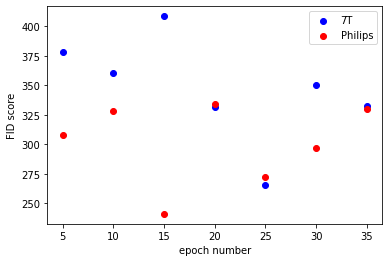

<Figure size 432x288 with 0 Axes>

In [13]:
for (pairs1,pairs2 ) in  zip(FID_epochs['SevenT'], FID_epochs['Philips']):
    plt.scatter(pairs1[1], pairs1[0], color = 'b', label= '7T')
    plt.scatter(pairs2[1], pairs2[0], color = 'r', label= 'Philips')

plt.legend(['7T', 'Philips'])
plt.ylabel('FID score')
plt.xlabel('epoch number')

plt.show()
plt.savefig('FID_scores.png', dpi=300)
with open('FID_epochs.txt', 'w') as outfile:
    json.dump(FID_epochs, outfile)